In [3]:
# Cell 1 — 先把目录里有哪些文件、文件名长什么样子，打印出来
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, random

X_TRAIN_DIR = Path(r".\data\X_train_uDRk9z9")
X_TEST_DIR  = Path(r".\data\X_test_xNbnvIa")
X_UNLAB_DIR = Path(r".\data\X_unlabeled_mtkxUlo")
Y_TRAIN_CSV = Path(r".\data\Y_train_T9NrBYo.csv")

def list_some(dir_path: Path, k=10):
    files = sorted(list(dir_path.rglob("*.npy")))
    if len(files) == 0:
        files = sorted(list(dir_path.rglob("*.NPY")))
    print(dir_path)
    print("n_files =", len(files))
    print("first few names:")
    for p in files[:k]:
        print(" ", p.name)
    return files

train_files = list_some(X_TRAIN_DIR, k=8)
test_files  = list_some(X_TEST_DIR,  k=8)
unlab_files = list_some(X_UNLAB_DIR, k=8)


data\X_train_uDRk9z9
n_files = 4410
first few names:
  well_1_section_0_patch_0.npy
  well_1_section_0_patch_1.npy
  well_1_section_0_patch_10.npy
  well_1_section_0_patch_11.npy
  well_1_section_0_patch_12.npy
  well_1_section_0_patch_13.npy
  well_1_section_0_patch_14.npy
  well_1_section_0_patch_15.npy
data\X_test_xNbnvIa
n_files = 972
first few names:
  well_10_section_0_patch_0.npy
  well_10_section_0_patch_1.npy
  well_10_section_0_patch_2.npy
  well_10_section_0_patch_3.npy
  well_10_section_0_patch_4.npy
  well_10_section_0_patch_5.npy
  well_10_section_0_patch_6.npy
  well_10_section_0_patch_7.npy
data\X_unlabeled_mtkxUlo
n_files = 1980
first few names:
  well_12_section_10_patch_0.npy
  well_12_section_10_patch_1.npy
  well_12_section_10_patch_10.npy
  well_12_section_10_patch_11.npy
  well_12_section_10_patch_2.npy
  well_12_section_10_patch_3.npy
  well_12_section_10_patch_4.npy
  well_12_section_10_patch_5.npy


In [4]:
# Cell 2 — 读一个 npy 看 shape / dtype / 数值范围 / NaN
def inspect_one_npy(path: Path):
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    print("file:", path.name)
    print("shape:", x.shape, "dtype:", x.dtype)
    print("has_nan:", np.isnan(x).any(), "has_inf:", np.isinf(x).any())
    x0 = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    print("min/max/mean/std:", float(x0.min()), float(x0.max()), float(x0.mean()), float(x0.std()))
    return x0

# 随便看几个
for p in train_files[:3]:
    _ = inspect_one_npy(p)
    print("-"*60)


file: well_1_section_0_patch_0.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -330.0 345.0 0.060822610294117646 36.19590855351595
------------------------------------------------------------
file: well_1_section_0_patch_1.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -189.0 192.0 -0.02741268382352941 26.921422071942036
------------------------------------------------------------
file: well_1_section_0_patch_10.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -246.0 184.0 0.07722886029411764 26.7090272702919
------------------------------------------------------------


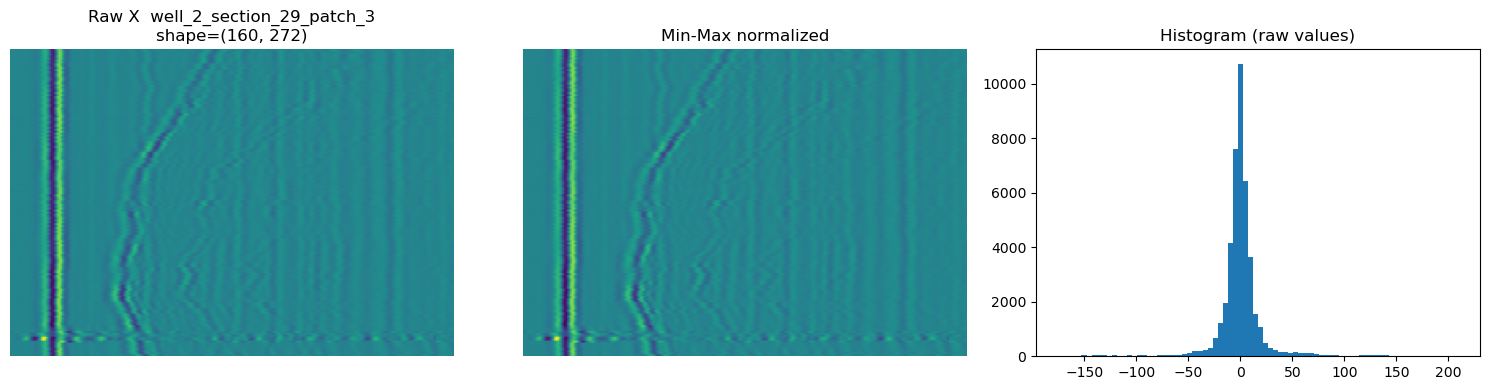

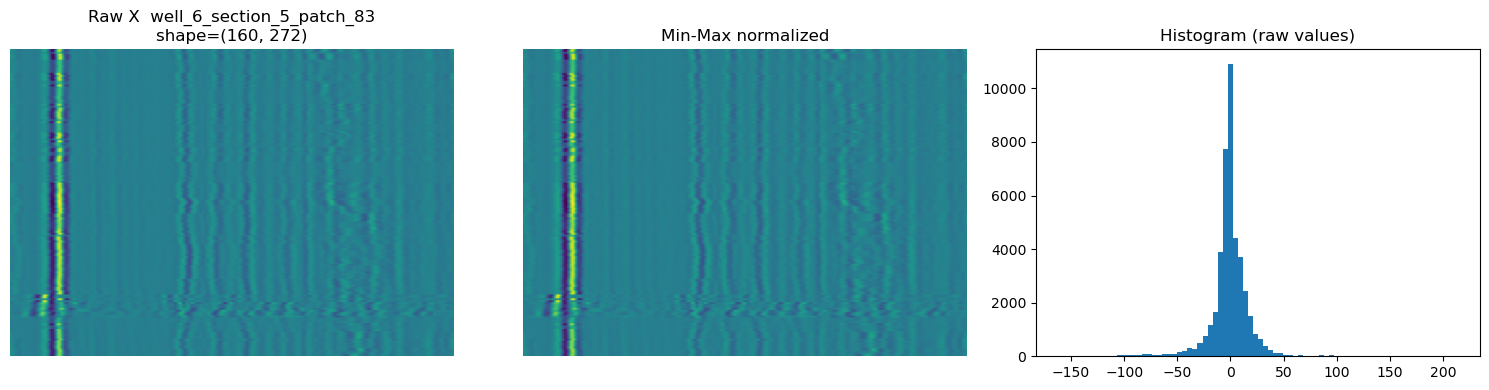

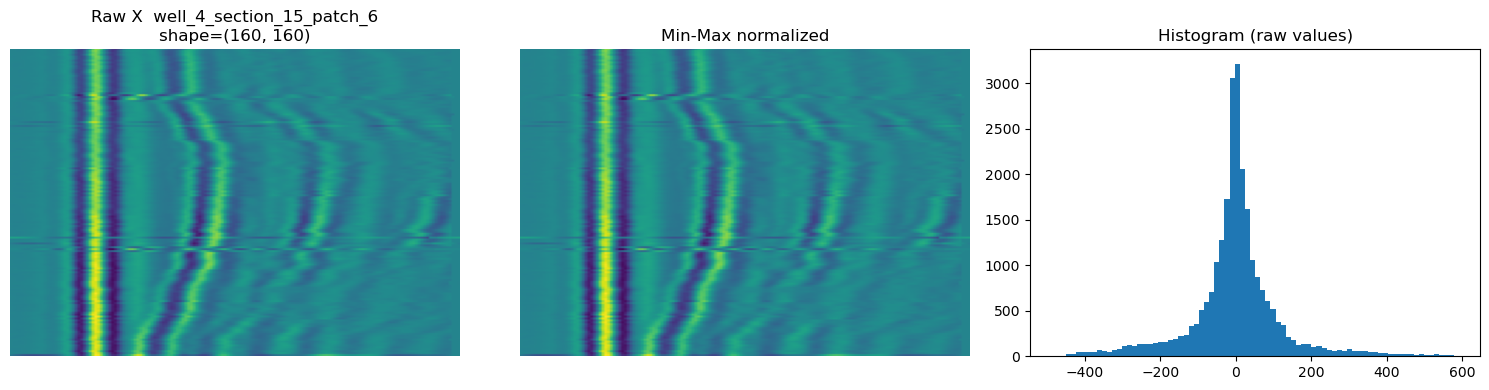

In [5]:
# Cell 3 — 把 X 画出来（原图 + min-max 归一化图 + 直方图）
def minmax_norm(x: np.ndarray) -> np.ndarray:
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        return (x - mn) / (mx - mn)
    return np.zeros_like(x, dtype=np.float32)

def show_x(path: Path):
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    xn = minmax_norm(x)

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.title(f"Raw X  {path.stem}\nshape={x.shape}")
    plt.imshow(x, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Min-Max normalized")
    plt.imshow(xn, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Histogram (raw values)")
    plt.hist(x.flatten(), bins=80)
    plt.tight_layout()
    plt.show()

# 看几张训练图
for p in random.sample(train_files, k=3):
    show_x(p)


y_df shape: (4410, 43520)
index example: well_2_section_22_patch_1


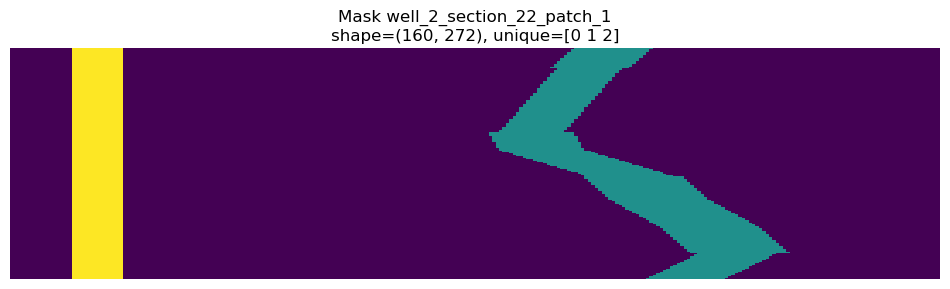

In [6]:
# Cell 4 — 读取 y_train.csv，并还原某个 patch 的 mask，看看长什么样
y_df = pd.read_csv(Y_TRAIN_CSV, index_col=0)
print("y_df shape:", y_df.shape)
print("index example:", y_df.index[0])

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]  # 去 padding
    mask = vals.reshape(160, -1)
    return mask.astype(np.int64)

def show_mask(name: str):
    row = y_df.loc[name].values
    m = restore_mask_from_row(row)
    plt.figure(figsize=(12, 3))
    plt.title(f"Mask {name}\nshape={m.shape}, unique={np.unique(m)}")
    plt.imshow(m, aspect="auto", interpolation="nearest")
    plt.axis("off")
    plt.show()
    return m

# 随便看一个 label
example_name = y_df.index[0]
_ = show_mask(example_name)


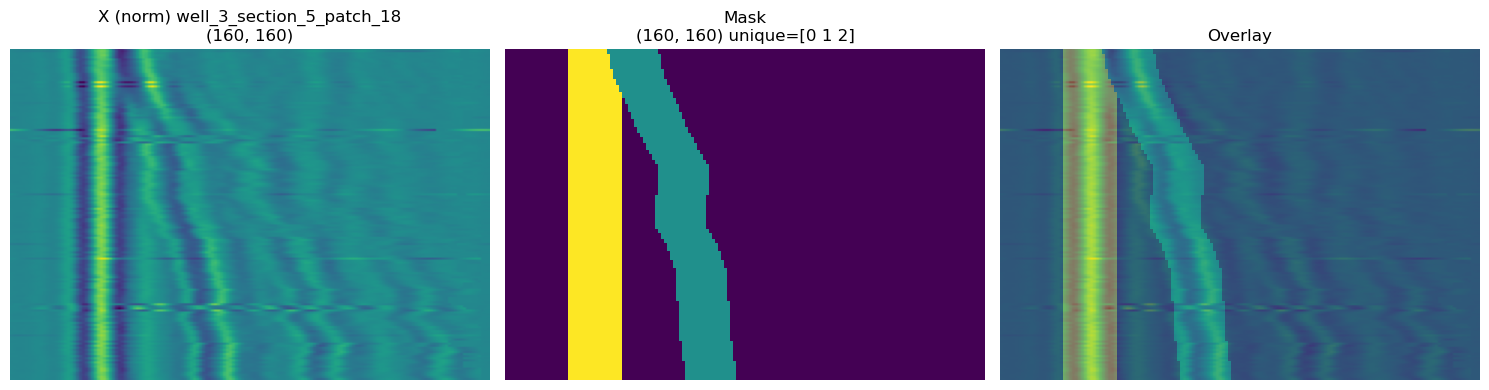

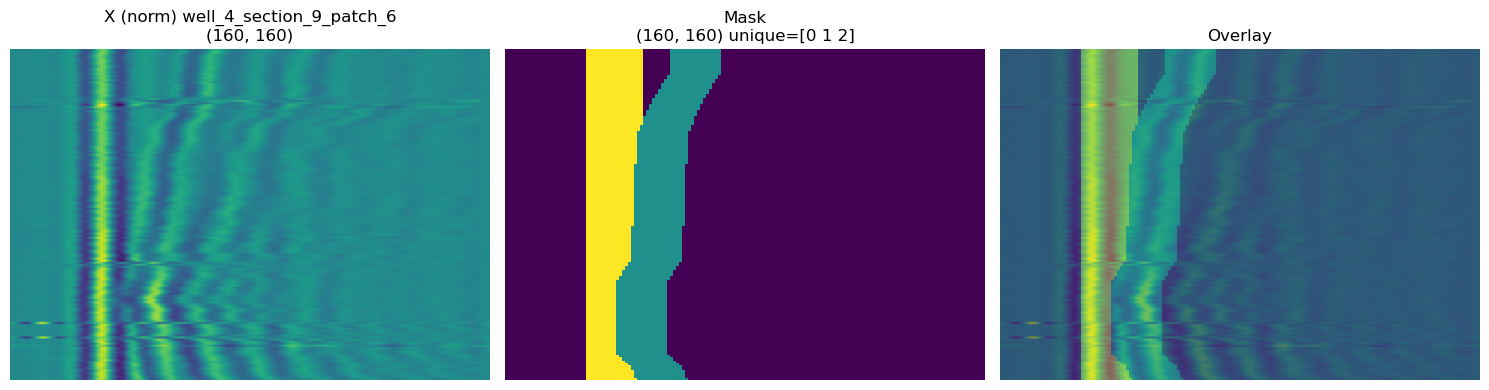

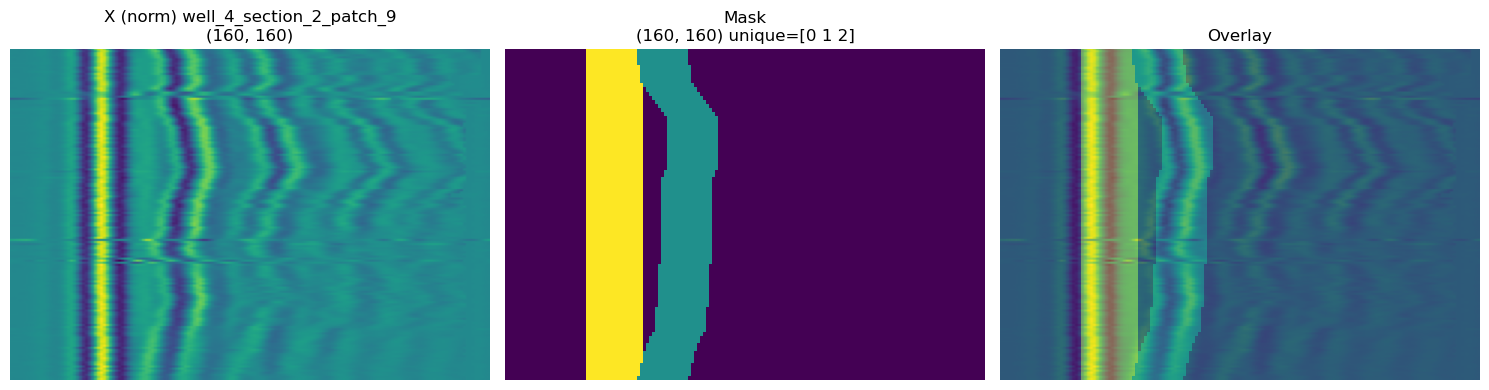

In [7]:
# Cell 5 — 把 X 和 mask 叠在一起看（确认对齐/标注合理）
# 注意：这里假设 X_train 里确实有同名文件 name.npy
def show_overlay(name: str):
    x_path = X_TRAIN_DIR / f"{name}.npy"
    if not x_path.exists():
        # 如果文件在子目录，用 rglob 找一下
        matches = list(X_TRAIN_DIR.rglob(f"{name}.npy"))
        if len(matches) == 0:
            matches = list(X_TRAIN_DIR.rglob(f"{name}.NPY"))
        if len(matches) == 0:
            raise FileNotFoundError(f"Cannot find {name}.npy under X_TRAIN_DIR")
        x_path = matches[0]

    x = np.load(x_path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    xn = minmax_norm(x)

    m = restore_mask_from_row(y_df.loc[name].values)

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.title(f"X (norm) {name}\n{x.shape}")
    plt.imshow(xn, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Mask\n{m.shape} unique={np.unique(m)}")
    plt.imshow(m, aspect="auto", interpolation="nearest")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(xn, aspect="auto")
    plt.imshow(m, alpha=0.35, aspect="auto", interpolation="nearest")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# 抽几个有标签的样本看叠加
for name in random.sample(list(y_df.index), k=3):
    show_overlay(name)


found in first 2000 labels -> 160: 328  272: 1672


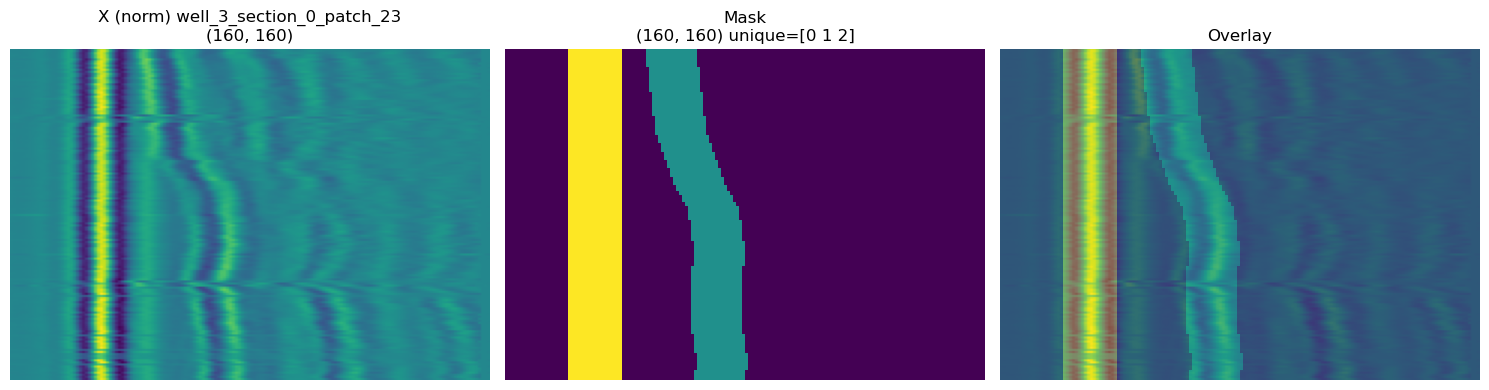

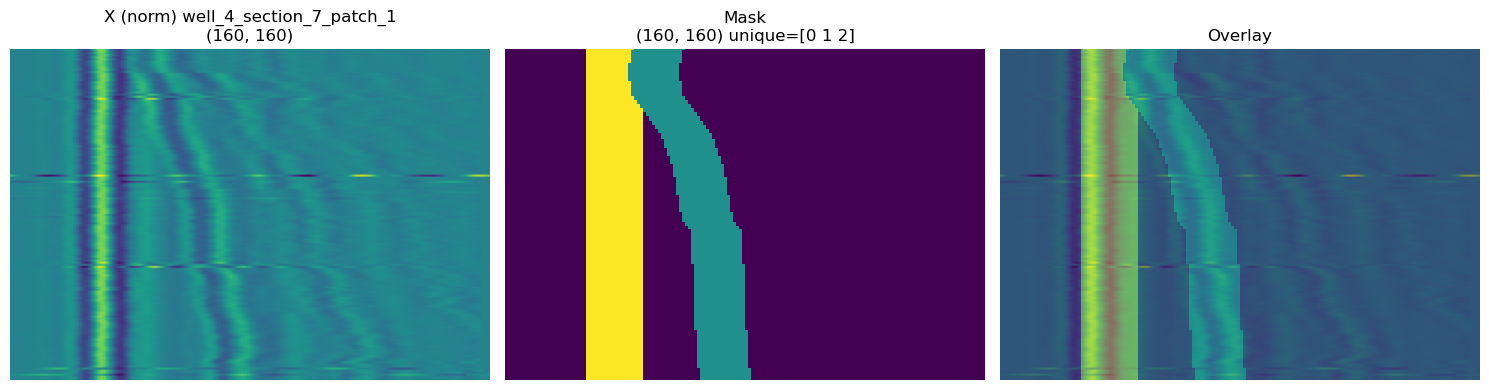

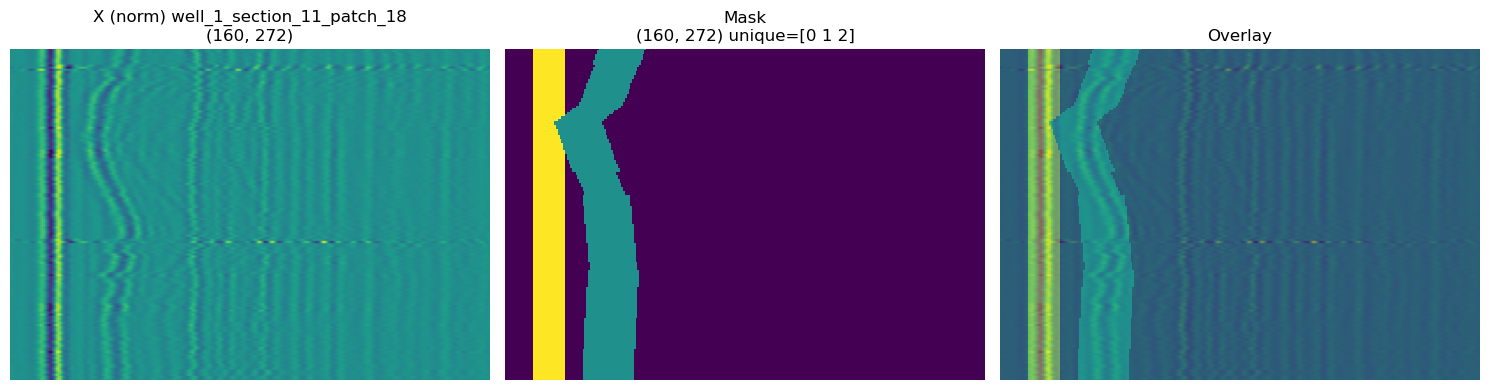

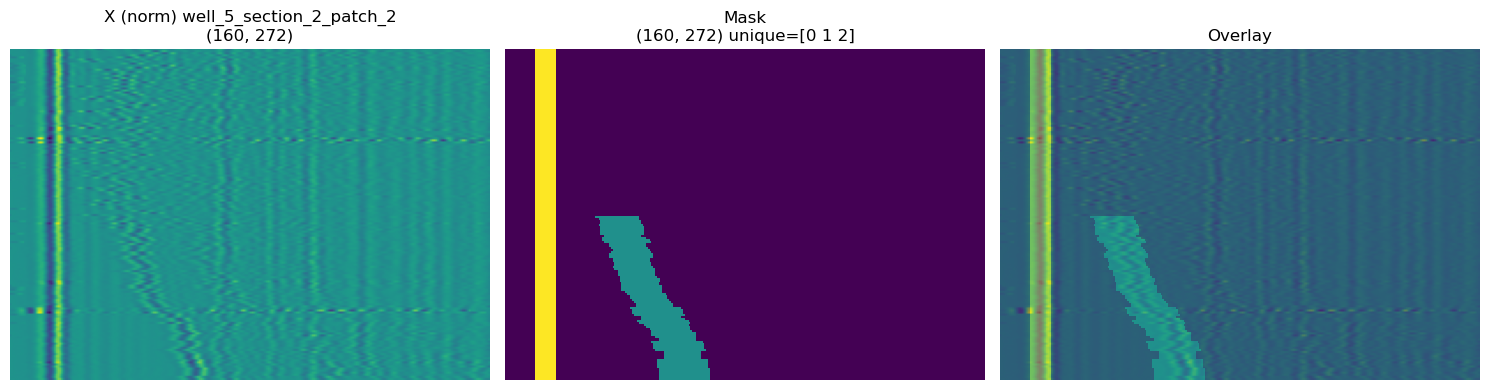

In [8]:
# Cell 6 — 看看 160×160 和 160×272 两种宽度各是什么样（各抽几张）
# 先从 y_train 里统计每个 patch 的 mask 宽度
def mask_width(name: str) -> int:
    m = restore_mask_from_row(y_df.loc[name].values)
    return int(m.shape[1])

names_160 = [n for n in y_df.index[:2000] if mask_width(n) == 160]
names_272 = [n for n in y_df.index[:2000] if mask_width(n) == 272]

print("found in first 2000 labels -> 160:", len(names_160), " 272:", len(names_272))

if len(names_160) > 0:
    for n in random.sample(names_160, k=min(2, len(names_160))):
        show_overlay(n)

if len(names_272) > 0:
    for n in random.sample(names_272, k=min(2, len(names_272))):
        show_overlay(n)


In [9]:
# Cell 7 — 全量统计：mask 宽度分布（160 vs 272）
from collections import Counter
import numpy as np
import pandas as pd

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]
    return vals.reshape(160, -1).astype(np.int64)

width_counter = Counter()
for name, row in y_df.iterrows():
    m = restore_mask_from_row(row.values)
    width_counter[m.shape[1]] += 1

width_counter


Counter({272: 3726, 160: 684})

In [10]:
# Cell 8 — 全量统计：类别像素占比 + patch-level presence（每类在多少patch里出现）
from collections import defaultdict

pixel_counts = defaultdict(int)     # label -> total pixels
presence_counts = defaultdict(int)  # label -> number of patches where label appears
n_patches = 0

for name, row in y_df.iterrows():
    m = restore_mask_from_row(row.values)
    n_patches += 1
    uniq = np.unique(m)
    for v in uniq:
        presence_counts[int(v)] += 1
    for v, c in zip(*np.unique(m, return_counts=True)):
        pixel_counts[int(v)] += int(c)

total_pixels = sum(pixel_counts.values())
stats = []
for k in sorted(pixel_counts.keys()):
    stats.append({
        "label": k,
        "total_pixels": pixel_counts[k],
        "pixel_ratio": pixel_counts[k] / total_pixels,
        "patch_presence": presence_counts[k],
        "presence_ratio": presence_counts[k] / n_patches
    })

class_stats_df = pd.DataFrame(stats).sort_values("label").reset_index(drop=True)
class_stats_df


,label,total_pixels,pixel_ratio,patch_presence,presence_ratio
0,0,153256840,0.853010,4410,1.000000
1,1,15970360,0.088889,4362,0.989116
2,2,10438720,0.058101,4410,1.000000


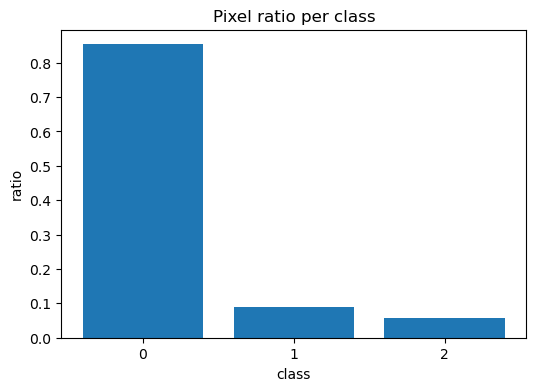

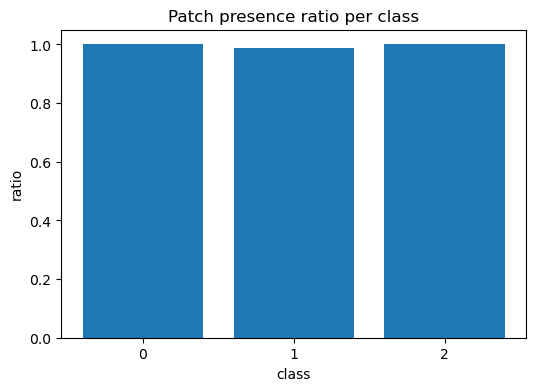

In [11]:
# Cell 9 — 可视化：像素占比柱状图（看类别不平衡程度）
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(class_stats_df["label"].astype(str), class_stats_df["pixel_ratio"])
plt.title("Pixel ratio per class")
plt.xlabel("class")
plt.ylabel("ratio")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(class_stats_df["label"].astype(str), class_stats_df["presence_ratio"])
plt.title("Patch presence ratio per class")
plt.xlabel("class")
plt.ylabel("ratio")
plt.show()


In [12]:
# Cell 10 — 按 well 统计：每口井有多少patch、以及两种宽度分别多少
def parse_well(name: str) -> int:
    # name like well_2_section_22_patch_1
    return int(name.split("_")[1])

well_counter = defaultdict(int)
well_width_counter = defaultdict(lambda: defaultdict(int))

for name in y_df.index:
    w = restore_mask_from_row(y_df.loc[name].values).shape[1]
    well = parse_well(name)
    well_counter[well] += 1
    well_width_counter[well][w] += 1

well_rows = []
for well in sorted(well_counter.keys()):
    wd = dict(well_width_counter[well])
    well_rows.append({
        "well": well,
        "n_patches": well_counter[well],
        "n_w160": wd.get(160, 0),
        "n_w272": wd.get(272, 0),
    })

pd.DataFrame(well_rows).sort_values("well")


,well,n_patches,n_w160,n_w272
0,1,666,0,666
1,2,1152,0,1152
2,3,486,486,0
3,4,198,198,0
4,5,288,0,288
5,6,1620,0,1620


In [13]:
# Cell 11 — 计算一个“建议的类别权重”（用于 Weighted CE），防止小类学不动
# 这里给一个常用做法：w_c = 1 / log(1.02 + p_c)
import numpy as np

eps = 1.02
p = class_stats_df.sort_values("label")["pixel_ratio"].values
weights = 1.0 / np.log(eps + p)
weights = weights / weights.mean()  # 归一化一下，方便训练稳定
weights


array([0.19459702, 1.18150312, 1.62389986])

In [14]:
y_train = pd.read_csv(Path('./data/Y_train_T9NrBYo.csv'), index_col=0) # Table with index being the name of the patch

In [15]:
np.array([v for v in y_train.loc['well_2_section_22_patch_1'] if v!=-1]).reshape(160,-1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(160, 272))

In [16]:
labels_patches = {}
for index_, values in y_train.iterrows():
    labels_patches[index_] = np.array([v for v in values if v!=-1]).reshape(160,-1)